In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [2]:
db_user = 'postgres'
db_password = '123456'
db_host = 'localhost'
db_port = '5432'
db_name = 'nordic_co2'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Finland

## General Analysis

In [3]:
query_fi_general = '''
WITH fi_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), fi_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), fi_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), fi_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), total_summary AS (
    SELECT * FROM fi_2021_summary
    UNION ALL
    SELECT * FROM fi_2022_summary
    UNION ALL
    SELECT * FROM fi_2023_summary
    UNION ALL
    SELECT * FROM fi_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    month_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, month_grouped;
'''

fi_general = pd.read_sql_query(query_fi_general, engine)

In [4]:
fi_general.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Finland,FI,1.0,136519.85,125542.07,-8.04,167583.69,154360.57,-7.89,42.19,71.17
1,2021,Finland,FI,2.0,125542.07,105406.65,-16.04,154360.57,134611.70,-12.79,43.22,71.08
2,2021,Finland,FI,3.0,105406.65,83774.09,-20.52,134611.70,111078.94,-17.48,47.20,77.16
3,2021,Finland,FI,4.0,83774.09,80082.08,-4.41,111078.94,104754.45,-5.69,49.83,81.57
4,2021,Finland,FI,5.0,80082.08,57792.59,-27.83,104754.45,78149.68,-25.40,53.95,82.55


In [5]:
fi_general.rename(columns={'year_':'year'}, inplace=True)
fi_general.rename(columns={'month_grouped':'month'}, inplace=True)

In [6]:
fi_general.dtypes

year                             object
country                          object
zone_id                          object
month                           float64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [7]:
fi_general.year = fi_general.year.astype(int)
fi_general.month = fi_general.month.astype(int)

### Statistics

In [8]:
fi_general.describe()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,48.000000,48.000000,48.000000,47.000000,47.000000,48.000000,47.000000,47.000000,48.000000,48.000000
mean,2022.500000,6.500000,56140.001042,54429.791489,3.549574,80314.443333,78457.650851,0.862553,51.779583,87.856458
std,1.129865,3.488583,35247.044013,33554.710919,38.658563,37606.844948,35720.214923,25.290449,5.158639,7.403728
min,2021.000000,1.000000,9877.660000,9877.660000,-54.270000,30353.910000,30353.910000,-41.000000,41.800000,71.080000
25%,2021.750000,3.750000,25940.545000,24961.210000,-25.235000,47763.985000,47734.580000,-18.100000,48.130000,82.305000
50%,2022.500000,6.500000,48108.140000,46850.070000,-6.980000,73316.035000,72522.960000,-3.320000,51.150000,89.835000
75%,2023.250000,9.250000,82234.535000,80901.715000,27.840000,107393.665000,106210.140000,15.850000,56.052500,94.177500
max,2024.000000,12.000000,139818.950000,139818.950000,115.930000,170061.880000,170061.880000,62.600000,61.560000,97.700000


<Axes: >

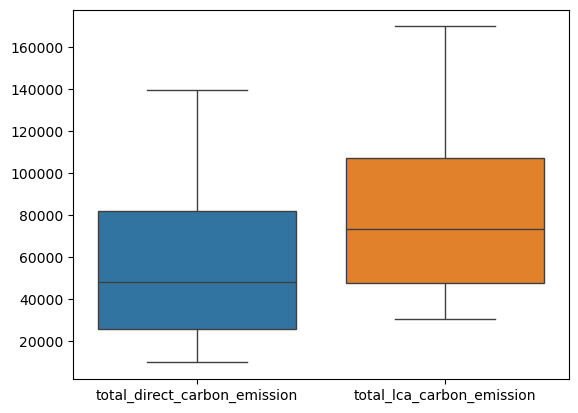

In [9]:
sns.boxplot(fi_general[['total_direct_carbon_emission', 'total_lca_carbon_emission']])

<Axes: >

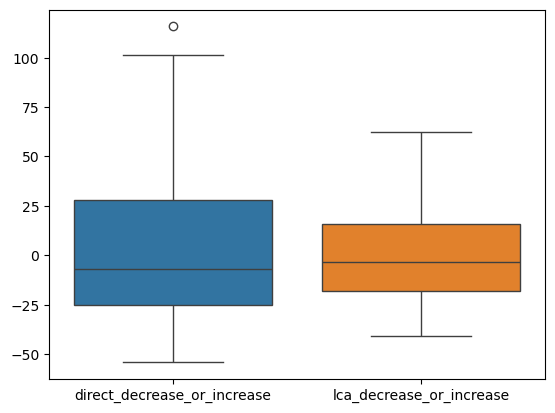

In [10]:
sns.boxplot(fi_general[['direct_decrease_or_increase', 'lca_decrease_or_increase']])

In [11]:
fi_general[fi_general['direct_decrease_or_increase'] > 100]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
30,2023,Finland,FI,7,12466.84,26919.88,115.93,30353.91,47793.39,57.45,41.80,96.90
33,2023,Finland,FI,10,21212.02,42759.21,101.58,40102.33,65204.83,62.60,52.57,95.38


In [12]:
fi_general.loc[[33, 34]]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Finland,FI,10,21212.02,42759.21,101.58,40102.33,65204.83,62.60,52.57,95.38
34,2023,Finland,FI,11,42759.21,51465.24,20.36,65204.83,75959.25,16.49,50.78,90.90


In [13]:
fi_general.select_dtypes(include='number').corr()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,4.864312e-14,-0.706176,-0.732127,0.005869,-0.694757,-0.719859,-0.006866,0.427717,0.726578
month,4.864312e-14,1.000000e+00,-0.240129,-0.024974,0.416038,-0.213091,0.004957,0.439849,0.133573,0.276402
total_direct_carbon_emission,-7.061763e-01,-2.401288e-01,1.000000,0.866828,-0.313284,0.996345,0.853885,-0.315296,-0.478943,-0.994787
next_direct_carbon_emission,-7.321269e-01,-2.497404e-02,0.866828,1.000000,0.110936,0.864156,0.995892,0.148751,-0.464960,-0.869597
direct_decrease_or_increase,5.869083e-03,4.160379e-01,-0.313284,0.110936,1.000000,-0.309951,0.127571,0.970076,-0.094485,0.301729
total_lca_carbon_emission,-6.947569e-01,-2.130909e-01,0.996345,0.864156,-0.309951,1.000000,0.856718,-0.315892,-0.452758,-0.987608
next_lca_carbon_emission,-7.198591e-01,4.957016e-03,0.853885,0.995892,0.127571,0.856718,1.000000,0.169878,-0.432509,-0.855216
lca_decrease_or_increase,-6.866031e-03,4.398492e-01,-0.315296,0.148751,0.970076,-0.315892,0.169878,1.000000,-0.035660,0.300566
avg_renewable_percentage,4.277172e-01,1.335733e-01,-0.478943,-0.464960,-0.094485,-0.452758,-0.432509,-0.035660,1.000000,0.490766
avg_low_carbon_percentage,7.265776e-01,2.764015e-01,-0.994787,-0.869597,0.301729,-0.987608,-0.855216,0.300566,0.490766,1.000000


In [14]:
#sns.pairplot(fi_general)

## Hourly Analysis

In [15]:
query_fi_hourly = '''
WITH fi_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), fi_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), fi_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), fi_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM finland.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), total_summary AS (
    SELECT * FROM fi_2021_summary
    UNION ALL
    SELECT * FROM fi_2022_summary
    UNION ALL
    SELECT * FROM fi_2023_summary
    UNION ALL
    SELECT * FROM fi_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    hour_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, hour_grouped
'''

fi_hourly = pd.read_sql_query(query_fi_hourly, engine)

In [16]:
fi_hourly.head(20)

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Finland,FI,0.0,47201.57,47452.57,0.53,59902.08,60167.36,0.44,44.36,79.13
1,2021,Finland,FI,1.0,47452.57,47423.93,-0.06,60167.36,60130.34,-0.06,44.20,79.00
2,2021,Finland,FI,2.0,47423.93,45953.11,-3.10,60130.34,58809.04,-2.20,44.65,79.05
3,2021,Finland,FI,3.0,45953.11,44800.88,-2.51,58809.04,57940.81,-1.48,46.48,79.85
4,2021,Finland,FI,4.0,44800.88,45692.41,1.99,57940.81,58889.60,1.64,48.35,80.57
5,2021,Finland,FI,5.0,45692.41,46201.83,1.11,58889.60,59445.25,0.94,49.17,80.34
6,2021,Finland,FI,6.0,46201.83,46419.03,0.47,59445.25,59684.34,0.40,49.79,80.23
7,2021,Finland,FI,7.0,46419.03,46244.04,-0.38,59684.34,59439.44,-0.41,50.03,80.18
8,2021,Finland,FI,8.0,46244.04,45949.33,-0.64,59439.44,59087.51,-0.59,50.08,80.22
9,2021,Finland,FI,9.0,45949.33,45830.07,-0.26,59087.51,58918.36,-0.29,50.08,80.31


In [17]:
fi_hourly

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Finland,FI,0.0,47201.57,47452.57,0.53,59902.08,60167.36,0.44,44.36,79.13
1,2021,Finland,FI,1.0,47452.57,47423.93,-0.06,60167.36,60130.34,-0.06,44.20,79.00
2,2021,Finland,FI,2.0,47423.93,45953.11,-3.10,60130.34,58809.04,-2.20,44.65,79.05
3,2021,Finland,FI,3.0,45953.11,44800.88,-2.51,58809.04,57940.81,-1.48,46.48,79.85
4,2021,Finland,FI,4.0,44800.88,45692.41,1.99,57940.81,58889.60,1.64,48.35,80.57
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024,Finland,FI,19.0,14890.31,14668.28,-1.49,26478.32,26224.07,-0.96,56.14,93.50
92,2024,Finland,FI,20.0,14668.28,14578.69,-0.61,26224.07,26217.54,-0.02,55.90,93.59
93,2024,Finland,FI,21.0,14578.69,14471.74,-0.73,26217.54,26135.11,-0.31,55.05,93.64
94,2024,Finland,FI,22.0,14471.74,14381.75,-0.62,26135.11,26065.66,-0.27,54.36,93.69


In [18]:
fi_hourly.rename(columns={'year_':'year'}, inplace=True)
fi_hourly.rename(columns={'hour_grouped':'hour'}, inplace=True)

In [19]:
fi_hourly.year = fi_hourly.year.astype(int)
fi_hourly.hour = fi_hourly.hour.astype(int)

In [20]:
#fi_hourly.to_excel('fi_hourly.xlsx')

In [21]:
fi_hourly.describe()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,95.000000,95.000000,96.000000,96.000000
mean,2022.500000,11.500000,28070.000521,27868.615579,-1.001579,40157.221667,39949.381053,-0.735474,51.785521,87.888958
std,1.123903,6.958524,12765.959071,12679.457664,5.995738,13504.583888,13420.984861,4.646635,3.034647,5.515292
min,2021.000000,0.000000,14381.750000,14381.750000,-44.800000,26065.660000,26065.660000,-36.510000,44.200000,79.000000
25%,2021.750000,5.750000,16695.742500,16160.735000,-0.640000,27575.580000,27422.430000,-0.460000,49.990000,84.162500
50%,2022.500000,11.500000,24954.700000,18412.920000,-0.060000,36856.215000,29282.550000,-0.140000,51.795000,89.255000
75%,2023.250000,17.250000,37138.520000,34519.185000,0.490000,50237.837500,47589.530000,0.355000,53.627500,92.770000
max,2024.000000,23.000000,47897.890000,47897.890000,5.180000,60579.800000,60579.800000,3.470000,56.840000,93.730000


<Axes: >

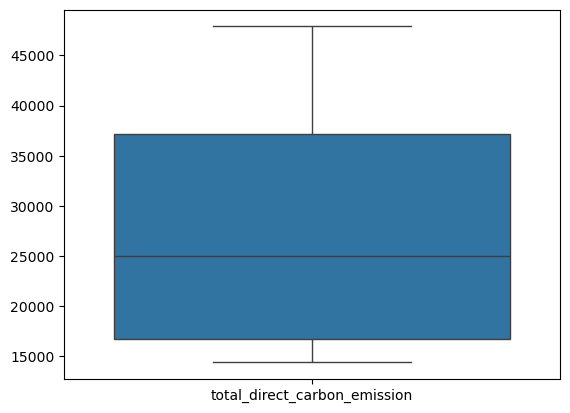

In [22]:
sns.boxplot(fi_hourly[['total_direct_carbon_emission']])

<Axes: >

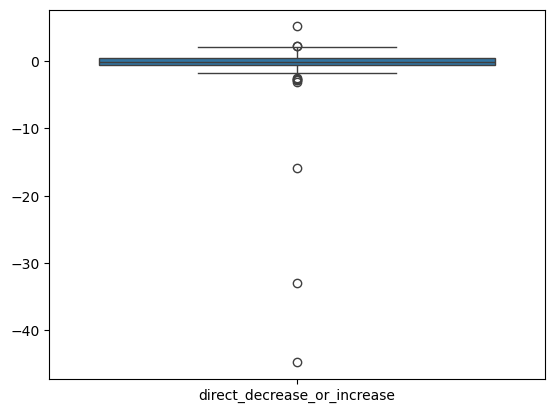

In [23]:
sns.boxplot(fi_hourly[['direct_decrease_or_increase']])

In [55]:
fi_hourly.direct_decrease_or_increase.max()

5.18

In [53]:
q1 = fi_hourly.direct_decrease_or_increase.quantile(0.25)
q3 = fi_hourly.direct_decrease_or_increase.quantile(0.75)

iqr = q3 - q1

inferior_limit = q1 - 1.5 * iqr
superior_limit = q3 + 1.5 * iqr

print(f'IL: {inferior_limit} | SL: {superior_limit}')

IL: -2.335 | SL: 2.1849999999999996


In [54]:
fi_hourly[(fi_hourly.direct_decrease_or_increase < inferior_limit) | (fi_hourly.direct_decrease_or_increase > superior_limit)]

,year,country,zone_id,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
2,2021,Finland,FI,2,47423.93,45953.11,-3.10,60130.34,58809.04,-2.20,44.65,79.05
3,2021,Finland,FI,3,45953.11,44800.88,-2.51,58809.04,57940.81,-1.48,46.48,79.85
17,2021,Finland,FI,17,45537.90,47897.89,5.18,58546.92,60579.80,3.47,51.08,80.50
19,2021,Finland,FI,19,47886.68,46623.60,-2.64,60309.81,58966.56,-2.23,48.53,79.12
23,2021,Finland,FI,23,47044.05,31521.95,-32.99,59637.29,44529.48,-25.33,44.83,79.23
27,2022,Finland,FI,3,32226.00,32972.37,2.32,45184.57,45913.69,1.61,51.41,86.18
43,2022,Finland,FI,19,33889.26,32942.02,-2.80,46661.89,45638.85,-2.19,53.44,85.58
47,2022,Finland,FI,23,31496.48,17385.52,-44.80,44429.88,28209.16,-36.51,50.90,86.42
52,2023,Finland,FI,4,17592.47,17986.44,2.24,28323.71,28722.10,1.41,50.44,92.41
67,2023,Finland,FI,19,17740.41,17238.49,-2.83,28251.77,27728.73,-1.85,51.75,92.35


In [61]:
fi_hourly[(fi_hourly.direct_decrease_or_increase >= inferior_limit) & (fi_hourly.direct_decrease_or_increase <= superior_limit)].max()

year                                2024
country                          Finland
zone_id                               FI
hour                                  22
total_direct_carbon_emission    47897.89
next_direct_carbon_emission     47886.68
direct_decrease_or_increase         2.15
total_lca_carbon_emission        60579.8
next_lca_carbon_emission        60309.81
lca_decrease_or_increase            1.64
avg_renewable_percentage           56.84
avg_low_carbon_percentage          93.69
dtype: object

In [24]:
fi_hourly.select_dtypes(include='number').corr()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,2.451147e-14,-0.969738,-0.954077,0.096749,-0.962256,-0.946746,0.104973,0.717829,0.967596
hour,2.451147e-14,1.000000e+00,0.002518,-0.029377,-0.336779,-0.004711,-0.036106,-0.312608,0.145839,-0.002202
total_direct_carbon_emission,-9.697383e-01,2.517657e-03,1.000000,0.985108,-0.083184,0.999075,0.984348,-0.096212,-0.621307,-0.999521
next_direct_carbon_emission,-9.540768e-01,-2.937737e-02,0.985108,1.000000,0.084083,0.984434,0.999061,0.071652,-0.585225,-0.983343
direct_decrease_or_increase,9.674925e-02,-3.367790e-01,-0.083184,0.084083,1.000000,-0.082205,0.084136,0.989524,0.189012,0.089066
total_lca_carbon_emission,-9.622561e-01,-4.710754e-03,0.999075,0.984434,-0.082205,1.000000,0.985386,-0.096269,-0.595673,-0.998101
next_lca_carbon_emission,-9.467456e-01,-3.610617e-02,0.984348,0.999061,0.084136,0.985386,1.000000,0.072482,-0.563002,-0.982234
lca_decrease_or_increase,1.049731e-01,-3.126076e-01,-0.096212,0.071652,0.989524,-0.096269,0.072482,1.000000,0.172462,0.101665
avg_renewable_percentage,7.178292e-01,1.458389e-01,-0.621307,-0.585225,0.189012,-0.595673,-0.563002,0.172462,1.000000,0.634355
avg_low_carbon_percentage,9.675955e-01,-2.202451e-03,-0.999521,-0.983343,0.089066,-0.998101,-0.982234,0.101665,0.634355,1.000000


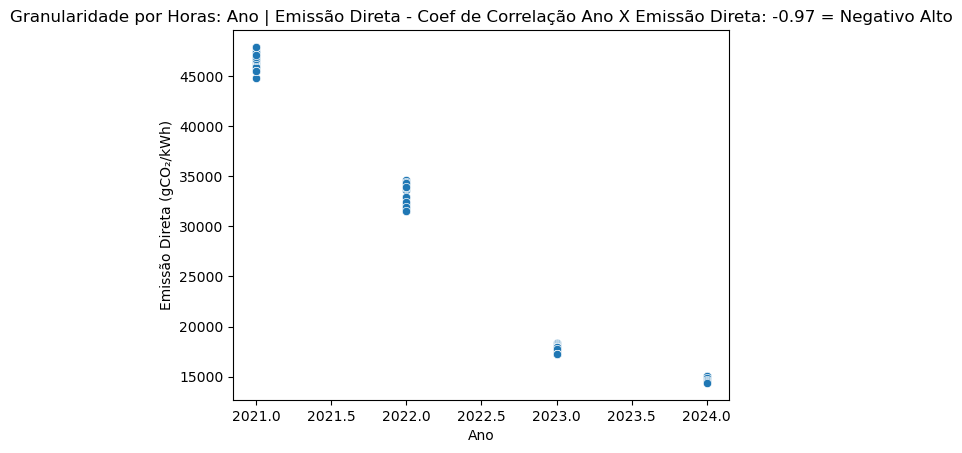

In [25]:
correlation = fi_hourly.year.corr(fi_hourly.total_direct_carbon_emission)

sns.scatterplot(data=fi_hourly, x='year', y='total_direct_carbon_emission')
plt.title(f'Granularidade por Horas: Ano | Emissão Direta - Coef de Correlação Ano X Emissão Direta: {correlation:.2f} = Negativo Alto')
plt.xlabel('Ano')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.show()

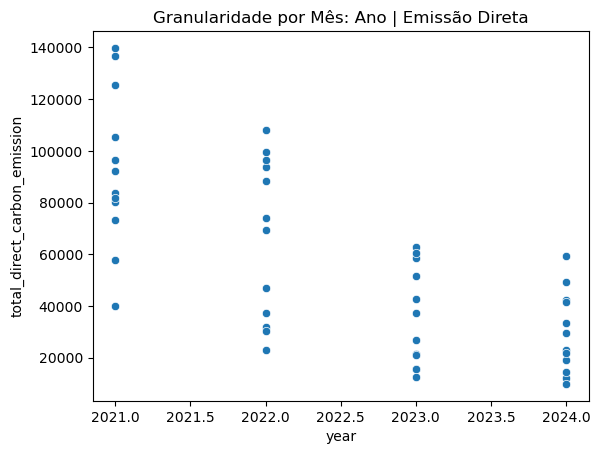

In [26]:
sns.scatterplot(data=fi_general, x='year', y='total_direct_carbon_emission')
plt.title('Granularidade por Mês: Ano | Emissão Direta')
plt.show()

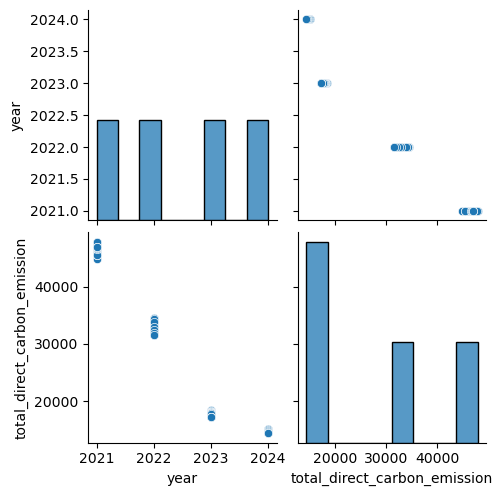

In [27]:
sns.pairplot(fi_hourly[['year', 'total_direct_carbon_emission']])

### 2021

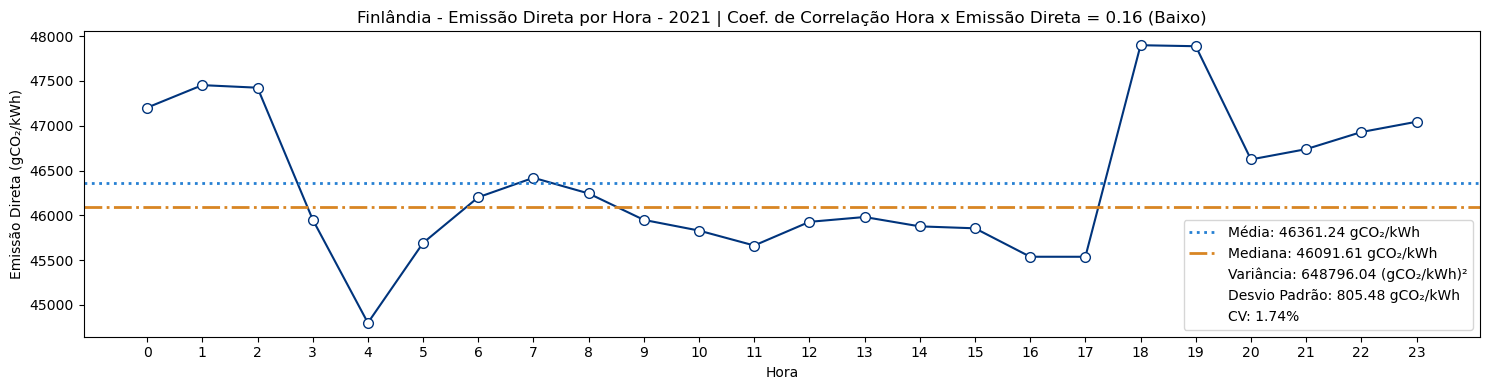

In [28]:
fi_hourly_2021 = fi_hourly[fi_hourly.year == 2021]

correlation = fi_hourly_2021.hour.corr(fi_hourly_2021.total_direct_carbon_emission)
mean = fi_hourly_2021.total_direct_carbon_emission.mean()
median = fi_hourly_2021.total_direct_carbon_emission.median()
std = fi_hourly_2021.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(fi_hourly_2021.hour, fi_hourly_2021.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Finlândia - Emissão Direta por Hora - 2021 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

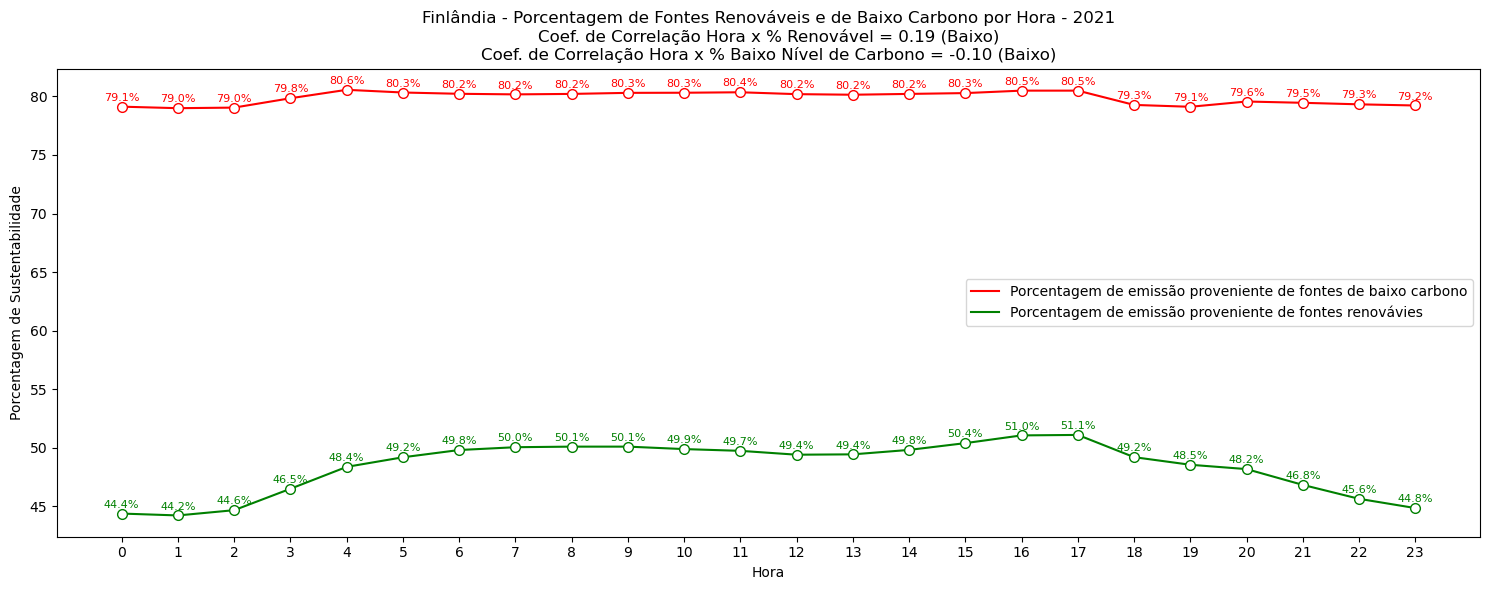

In [ ]:
fi_hourly_2021 = fi_hourly[fi_hourly.year == 2021]

correlation_renewable = fi_hourly_2021.hour.corr(fi_hourly_2021.avg_renewable_percentage)
correlation_low_carbon = fi_hourly_2021.hour.corr(fi_hourly_2021.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(fi_hourly_2021.hour, fi_hourly_2021.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2021.hour, fi_hourly_2021.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(fi_hourly_2021.hour, fi_hourly_2021.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2021.hour, fi_hourly_2021.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Finlândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2021\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

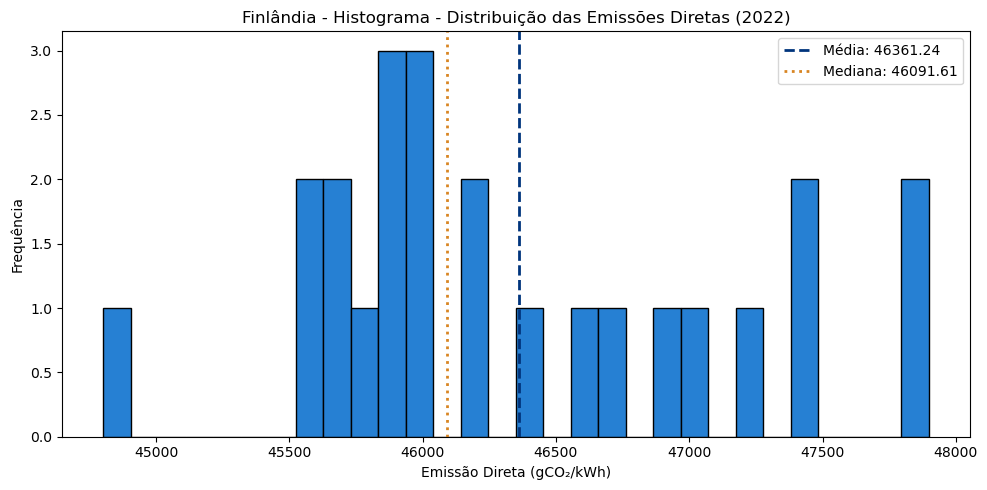

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(fi_hourly_2021.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(fi_hourly_2021.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {fi_hourly_2021.total_direct_carbon_emission.mean():.2f}')
plt.axvline(fi_hourly_2021.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {fi_hourly_2021.total_direct_carbon_emission.median():.2f}')
plt.title('Finlândia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

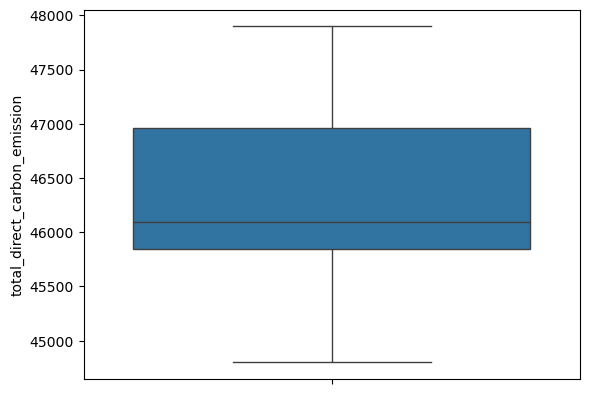

In [31]:
sns.boxplot(fi_hourly_2021.total_direct_carbon_emission)

In [32]:
fi_hourly.groupby('hour')['total_direct_carbon_emission'].max().reset_index().sort_values('total_direct_carbon_emission', ascending=False)

,hour,total_direct_carbon_emission
18,18,47897.89
19,19,47886.68
1,1,47452.57
2,2,47423.93
0,0,47201.57
23,23,47044.05
22,22,46929.17
21,21,46738.48
20,20,46623.60
7,7,46419.03


### 2022

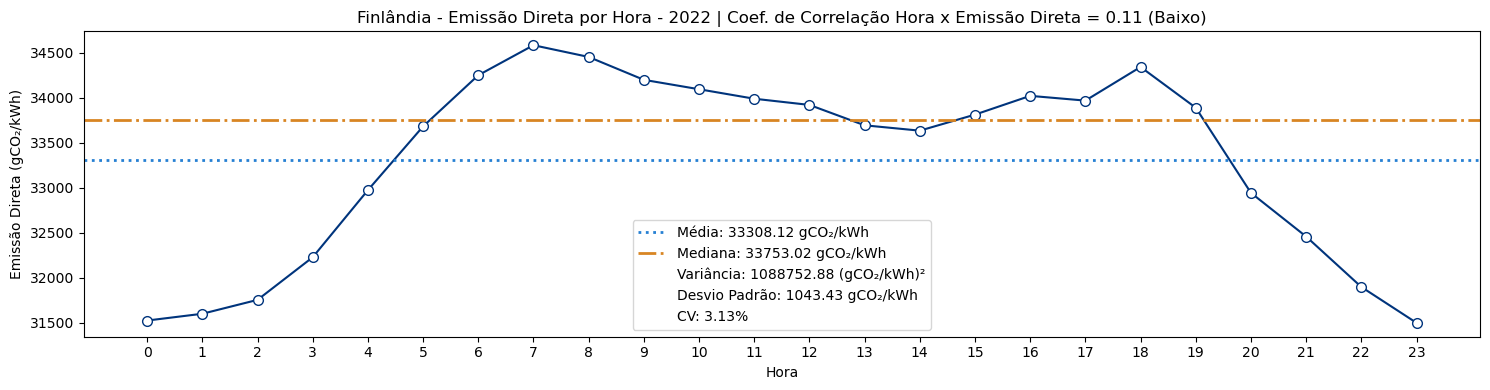

In [ ]:
fi_hourly_2022 = fi_hourly[fi_hourly.year == 2022]

correlation = fi_hourly_2022.hour.corr(fi_hourly_2022.total_direct_carbon_emission)
mean = fi_hourly_2022.total_direct_carbon_emission.mean()
median = fi_hourly_2022.total_direct_carbon_emission.median()
std = fi_hourly_2022.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(fi_hourly_2022.hour, fi_hourly_2022.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Finlândia - Emissão Direta por Hora - 2022 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

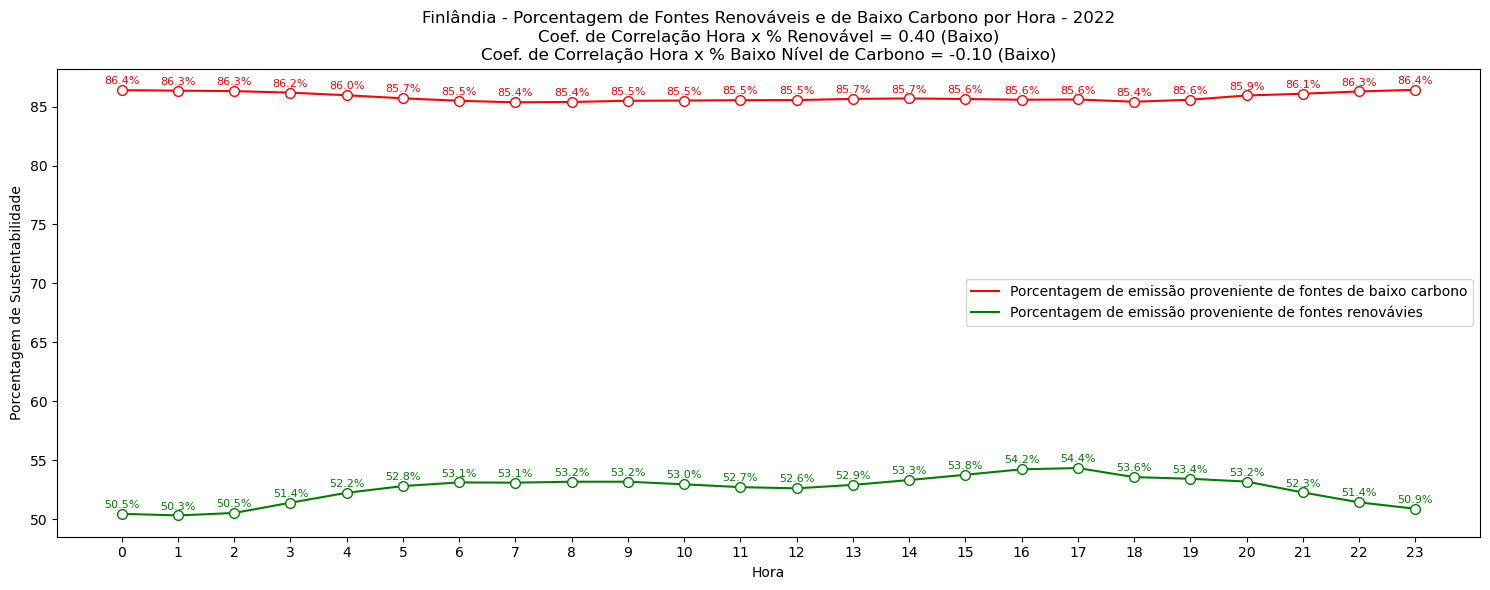

In [ ]:
fi_hourly_2022 = fi_hourly[fi_hourly.year == 2022]

correlation_renewable = fi_hourly_2022.hour.corr(fi_hourly_2022.avg_renewable_percentage)
correlation_low_carbon = fi_hourly_2022.hour.corr(fi_hourly_2022.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(fi_hourly_2022.hour, fi_hourly_2022.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2022.hour, fi_hourly_2022.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(fi_hourly_2022.hour, fi_hourly_2022.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2022.hour, fi_hourly_2022.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Finlândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2022\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

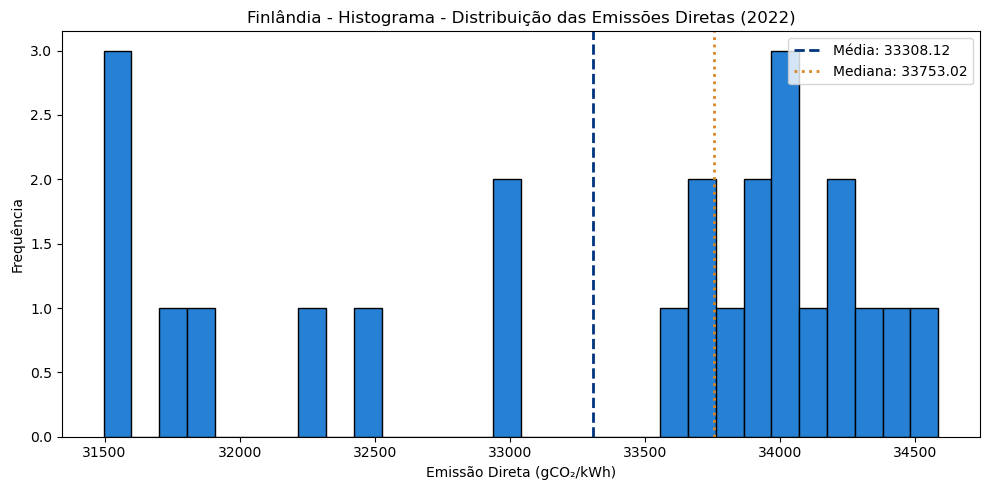

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(fi_hourly_2022.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(fi_hourly_2022.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {fi_hourly_2022.total_direct_carbon_emission.mean():.2f}')
plt.axvline(fi_hourly_2022.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {fi_hourly_2022.total_direct_carbon_emission.median():.2f}')
plt.title('Finlândia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

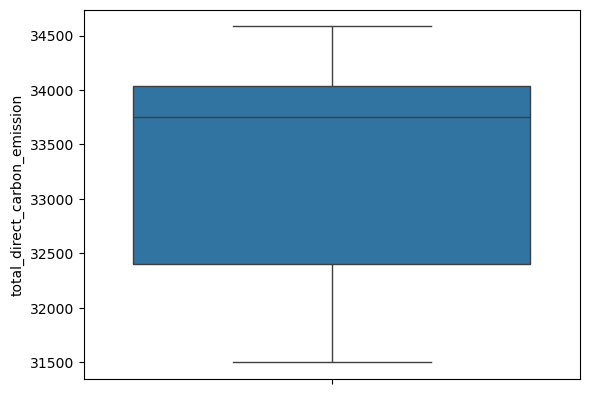

In [36]:
sns.boxplot(fi_hourly_2022.total_direct_carbon_emission)

### 2023

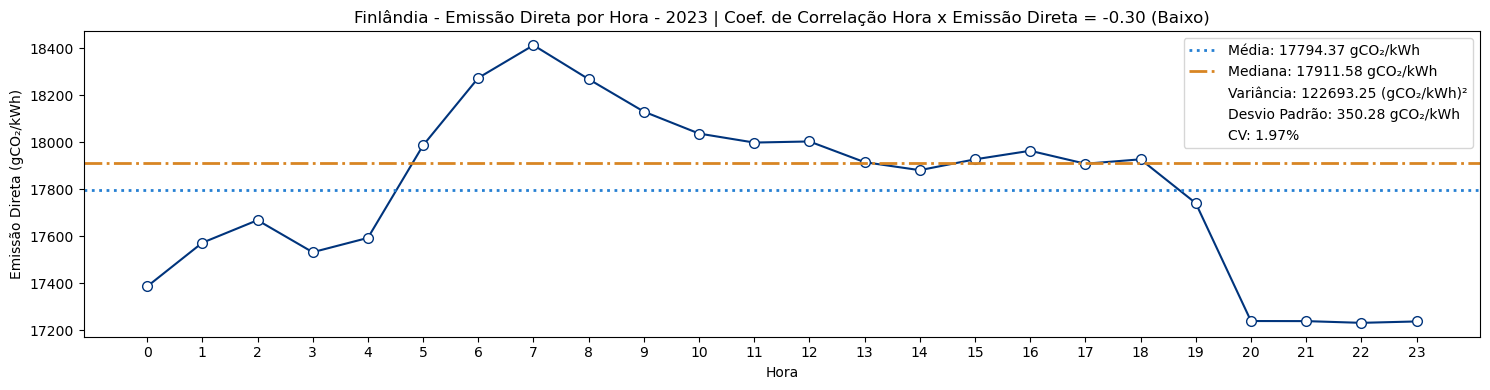

In [37]:
fi_hourly_2023 = fi_hourly[fi_hourly.year == 2023]

correlation = fi_hourly_2023.hour.corr(fi_hourly_2023.total_direct_carbon_emission)
mean = fi_hourly_2023.total_direct_carbon_emission.mean()
median = fi_hourly_2023.total_direct_carbon_emission.median()
std = fi_hourly_2023.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(fi_hourly_2023.hour, fi_hourly_2023.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Finlândia - Emissão Direta por Hora - 2023 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

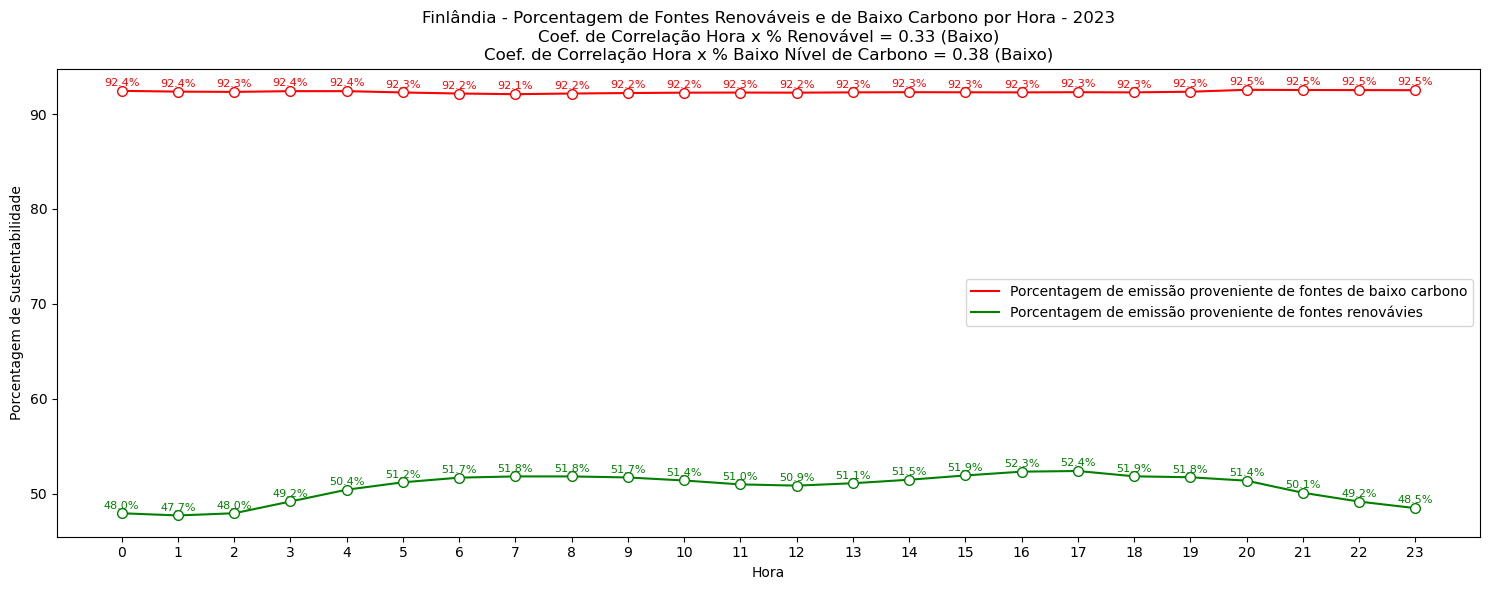

In [ ]:
fi_hourly_2023 = fi_hourly[fi_hourly.year == 2023]

correlation_renewable = fi_hourly_2023.hour.corr(fi_hourly_2023.avg_renewable_percentage)
correlation_low_carbon = fi_hourly_2023.hour.corr(fi_hourly_2023.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(fi_hourly_2023.hour, fi_hourly_2023.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2023.hour, fi_hourly_2023.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(fi_hourly_2023.hour, fi_hourly_2023.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2023.hour, fi_hourly_2023.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Finlândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2023\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

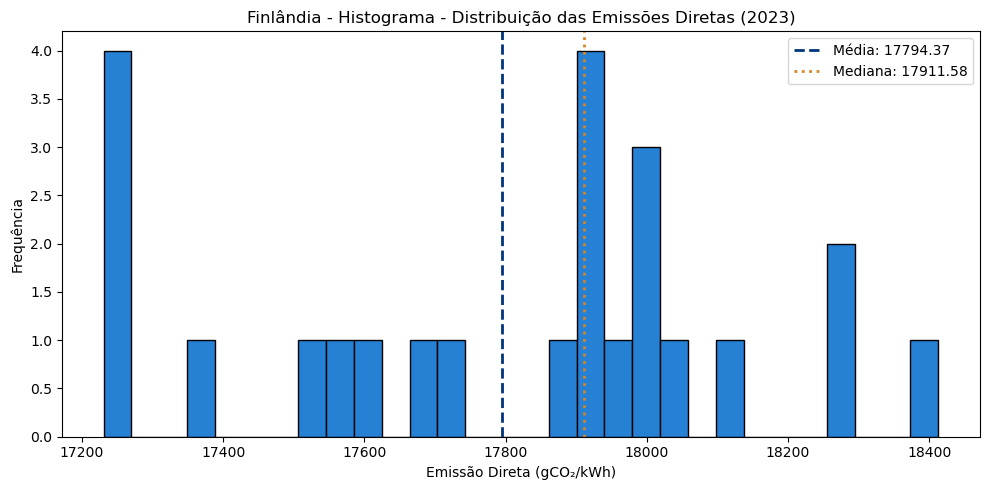

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(fi_hourly_2023.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(fi_hourly_2023.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {fi_hourly_2023.total_direct_carbon_emission.mean():.2f}')
plt.axvline(fi_hourly_2023.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {fi_hourly_2023.total_direct_carbon_emission.median():.2f}')
plt.title('Finlândia - Histograma - Distribuição das Emissões Diretas (2023)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

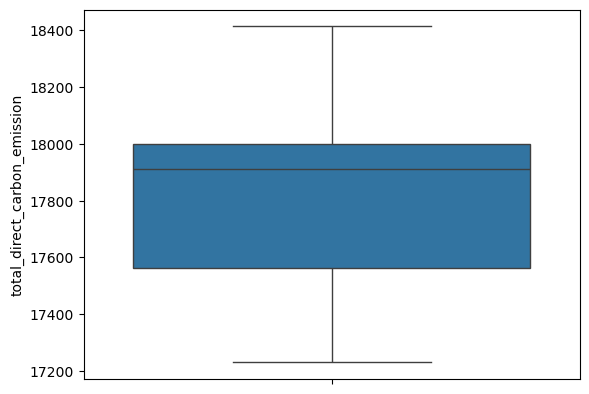

In [40]:
sns.boxplot(fi_hourly_2023.total_direct_carbon_emission)

### 2024

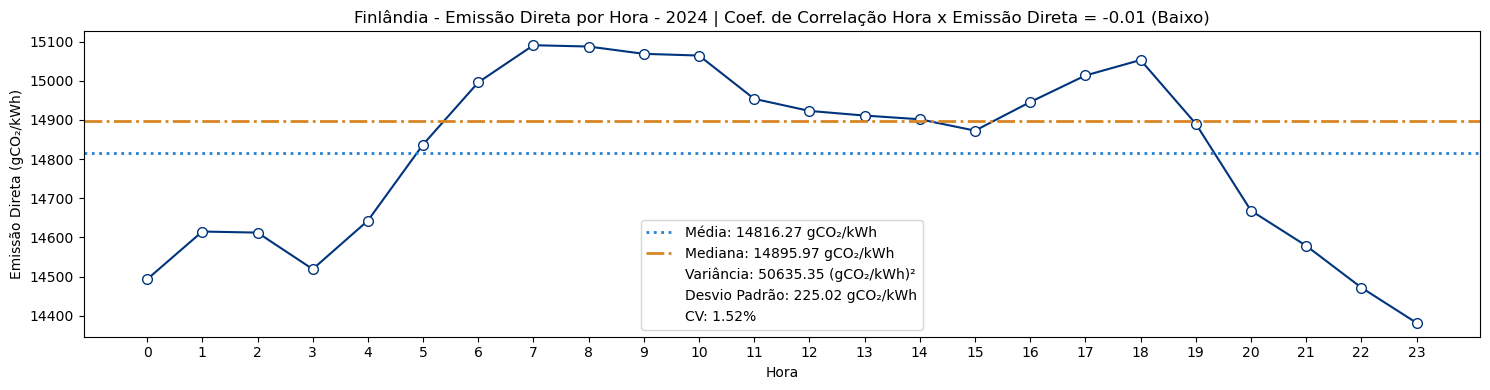

In [41]:
fi_hourly_2024 = fi_hourly[fi_hourly.year == 2024]

correlation = fi_hourly_2024.hour.corr(fi_hourly_2024.total_direct_carbon_emission)
mean = fi_hourly_2024.total_direct_carbon_emission.mean()
median = fi_hourly_2024.total_direct_carbon_emission.median()
std = fi_hourly_2024.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(fi_hourly_2024.hour, fi_hourly_2024.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Finlândia - Emissão Direta por Hora - 2024 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

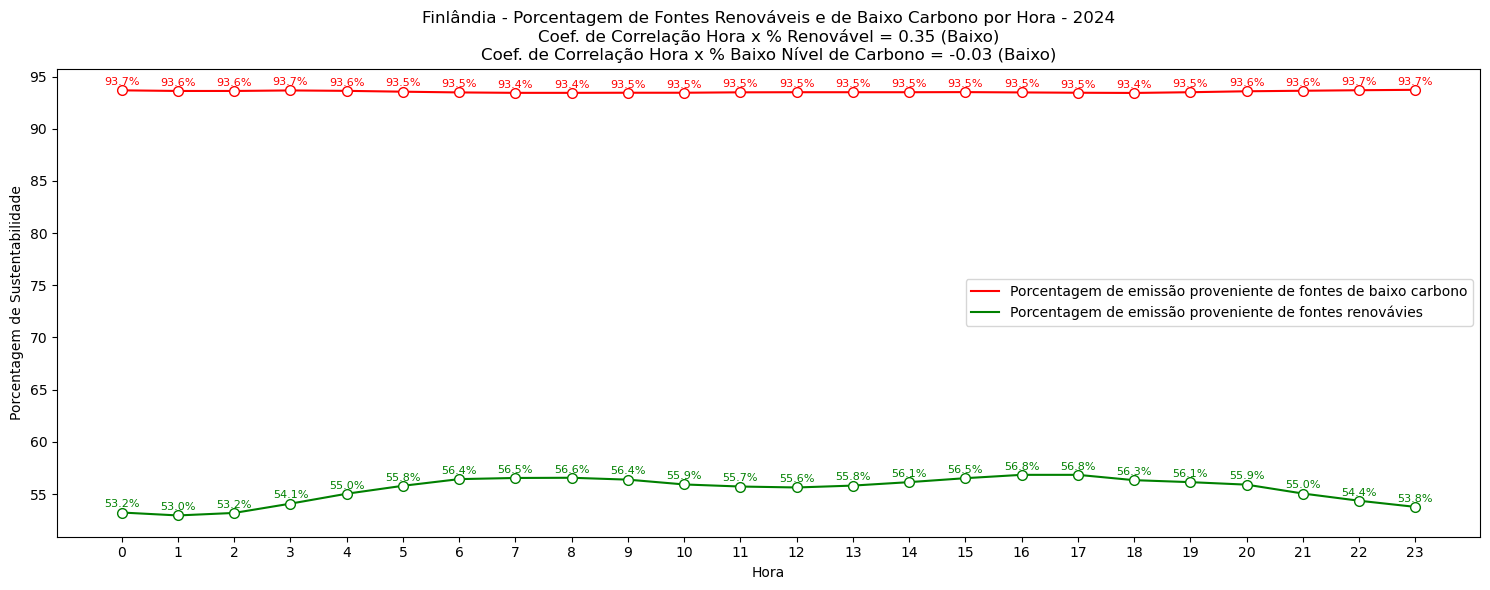

In [ ]:
fi_hourly_2024 = fi_hourly[fi_hourly.year == 2024]

correlation_renewable = fi_hourly_2024.hour.corr(fi_hourly_2024.avg_renewable_percentage)
correlation_low_carbon = fi_hourly_2024.hour.corr(fi_hourly_2024.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(fi_hourly_2024.hour, fi_hourly_2024.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2024.hour, fi_hourly_2024.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(fi_hourly_2024.hour, fi_hourly_2024.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(fi_hourly_2024.hour, fi_hourly_2024.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Finlândia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2024\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

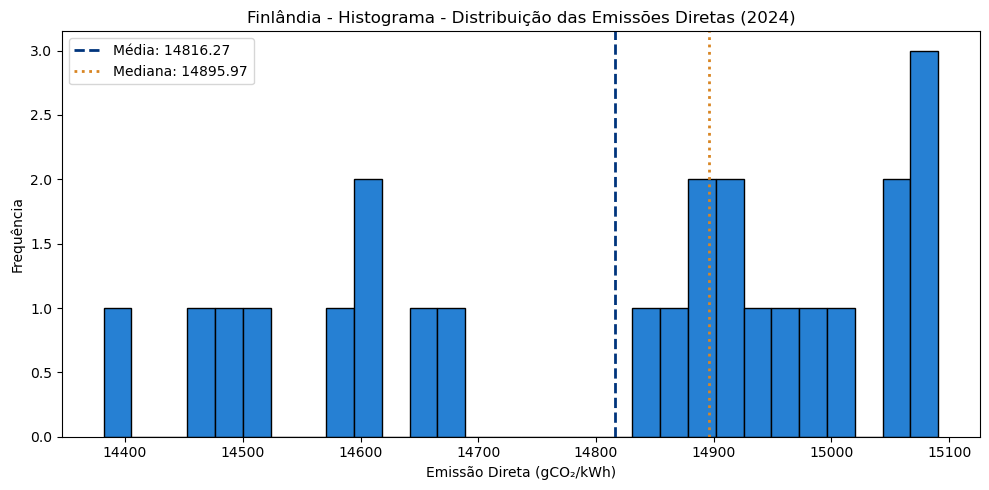

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(fi_hourly_2024.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(fi_hourly_2024.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {fi_hourly_2024.total_direct_carbon_emission.mean():.2f}')
plt.axvline(fi_hourly_2024.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {fi_hourly_2024.total_direct_carbon_emission.median():.2f}')
plt.title('Finlândia - Histograma - Distribuição das Emissões Diretas (2024)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

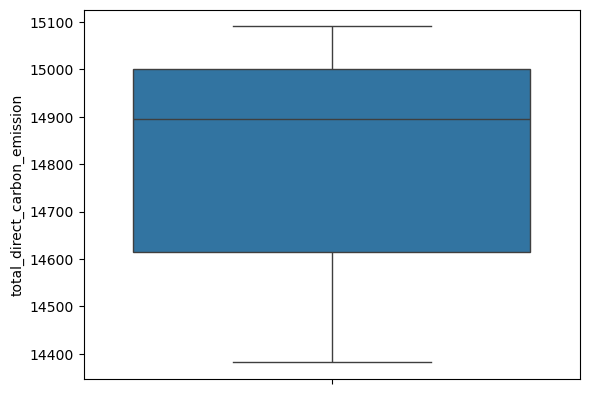

In [44]:
sns.boxplot(fi_hourly_2024.total_direct_carbon_emission)